In [1]:
import sys; import numpy as np; from collections.abc import Iterable

# Input data format
from calculations_file_format_single_event import return_result_dtype, Qn_species, Qn_diff_pT_cuts

result_dtype = return_result_dtype('ALICE')
data = np.fromfile('../../../../../2159949.results.dat', dtype=result_dtype)


# Examining the input
nev = len(data['ALICE'][:,0]['dNch_deta']) 
print(nev)
#for i in range(4835): print (data['ALICE'][:,0]['dNch_deta'][i])
#print (len(data['ALICE'][:,0]['flow'][i][1]))
#for i in range(4835): print ( data['ALICE'][:,0]['flow'][i][1][1])
#print((data['ALICE']['flow']['N'][0:4835, 0][4834]))
#print((data['initial_entropy']))

# Note: for 2.76 TeV file use "1" for viscous correction selection index in file format, for 5.02 file use "0"

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'run_id': 'production_500pts_Pb_Pb_2760', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 324, 326, 459, 429, 334, 462, 242, 341, 406, 440, 377, 123, 447], 'npc': 10, 'MAP_obs_file': 'main.dat'}}
4835


In [2]:
# Define the bin edges and centers
pT_bins = Qn_diff_pT_cuts
mid_pT_bins=[(pT_bins[i]+pT_bins[i+1])/2. for i in range(0,len(pT_bins)-1)]
#print((mid_pT_bins))

# Pick out the pT-differential Qn array
Qn_diff=data['d_flow_pid']

# Pick out the pid tuples
Qn_species_no_Ch=[tmp for tmp in Qn_species if tmp[0] != "Ch"]

In [3]:
# Define jacobian function
def integrated_jacobian(m, pT, etaCut):

    m2=m*m
    pT2=pT*pT
    cosh2EtaCut=np.cosh(2*etaCut)
    sinhEtaCut=np.sinh(etaCut)

    return np.log((np.sqrt(2*m2 + pT2 + pT2*cosh2EtaCut) + np.sqrt(2)*pT*sinhEtaCut)/(np.sqrt(2*m2 + pT2 + pT2*cosh2EtaCut) - np.sqrt(2)*pT*sinhEtaCut))

masses={
'pion':0.138,
'kaon':0.494,
'proton':0.938,
'Sigma':1.189,
'Xi':1.318
}

In [4]:
# Set kinematic cuts
pTminCut = .2
pTmaxCut = 3
etaCut = .8
Qn_rap_range = 2

In [5]:
# read in the pT-differential data
# Create and fill arrays with Qn values in each pT bin

# N_diff is the number of particles, Q2-4_diff are the pT-differential Q-vectors
N_diff = np.zeros(nev); Q2_diff = np.zeros(nev, dtype=complex); Q3_diff = np.zeros(nev, dtype=complex); Q4_diff = np.zeros(nev, dtype=complex); 

# pt1-2_diff are the first and second pT moments using best approximation formula from the differential data
pt1_diff = np.zeros(nev); pt2_diff = np.zeros(nev);

for k in range(nev): # looping over events
    Qn_ch = np.zeros(1,dtype=[('N', '<f8', 4), ('Qn', '<c16', (4,5))])
    Q0 = np.zeros(len(mid_pT_bins))
    for species, pid in Qn_species_no_Ch: # looping over charged particles
        weight=1
        if (species== 'Sigma'):
            weight=2

        for i, pT in enumerate(mid_pT_bins): # looping over the pT-differential bins
            if (pT<pTminCut or pT>pTmaxCut):
                continue
            rapidity_to_pseudorapidity_jacobian=integrated_jacobian(masses[species],pT,etaCut)
            n = Qn_diff[species]['N'][k][:,i]/Qn_rap_range*weight*rapidity_to_pseudorapidity_jacobian
            Q0[i] += n[0] # used for the pT moment calculation
            Qn_ch['N']+=n
            Qn_ch['Qn']+=Qn_diff[species]['Qn'][k][:,i]/Qn_rap_range*weight*rapidity_to_pseudorapidity_jacobian

    
    # calculate the pT moments (not needed for vn calculation)
    temp = np.array(mid_pT_bins)*Q0
    pt1_diff[k] = np.sum(temp)
    temp2 = (np.array(mid_pT_bins)**2.)*Q0
    pt2_diff[k] = np.sum(temp2)

    # enter final values in 1D arrays (not necessary step)
    N_diff[k] = Qn_ch[0][0][0]
    Q2_diff[k] = Qn_ch[0][1][0][1]
    Q3_diff[k] = Qn_ch[0][1][0][2]
    Q4_diff[k] = Qn_ch[0][1][0][3]

In [6]:
# Sort the mean Qn event-arrays by the charged particle multiplicity in descending order
N = np.zeros(nev); Q2 = np.zeros(nev, dtype=complex); Q3 = np.zeros(nev, dtype=complex); Q4 = np.zeros(nev, dtype=complex); Nch = np.zeros(nev)

sort = np.array(sorted(range(nev), key = lambda x: data['ALICE'][:,0]['dNch_deta'][x], reverse=True))
for i in range(nev):
    
        # You may use the pre-calculated, integrated Q-vectors read directly from the input data (pT[0.2, 5.0], eta [-0.8, 0.8])
    Q2[i] = data['ALICE']['flow']['Qn'][0:nev, 0, 1][sort[i]]
    Q3[i] = data['ALICE']['flow']['Qn'][0:nev, 0, 2][sort[i]]
    Q4[i] = data['ALICE']['flow']['Qn'][0:nev, 0, 3][sort[i]]
    N[i] = data['ALICE']['flow']['N'][0:nev, 0][sort[i]]
    
    Nch[i] = data['ALICE'][:,0]['dNch_deta'][sort[i]]
    
        # You may use the pT-differential Q-vectors calculated above (comment out one or the other or define new arrays)
#     Q2[i] = Q2_diff[sort[i]]
#     Q3[i] = Q3_diff[sort[i]]
#     Q4[i] = Q4_diff[sort[i]]
#     N[i] = N_diff[sort[i]]

# check the sorted output 
#for i in range(4835): print (i,data['ALICE'][:,0]['dNch_deta'][i],sort[i],Nch[i],N[i],np.imag(Q2[i]))

In [23]:
# Calculate vn from Q-vectors and average over events in each centrality bin 
    # ALICE centrality bins
cen = np.array([[0,5],[5,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70]])
    # event number bin thresholds
index = (cen/100.*nev).astype(int)
    # centrality bin centers
cenM = np.mean(cen, axis=1)

vn = np.zeros((3,len(cenM)))

for i, (nl,nh) in enumerate(zip(index[:,0], index[:,1])):
    x = N[nl:nh]; y2 = Q2[nl:nh]; y3 = Q3[nl:nh]; y4 = Q4[nl:nh]
    w = x*(x-1.)
    #z = np.zeros(len(w)) + 1   # for weights=1
    cn2_2 = (np.abs(y2)**2 - x)/(x*(x-1.)); cn3_2 = (np.abs(y3)**2 - x)/w; cn4_2 = (np.abs(y4)**2 - x)/w
    mean_2 = np.average(cn2_2, weights=w); mean_3 = np.average(cn3_2, weights=w); mean_4 = np.average(cn4_2, weights=w)
    vn[0][i]=np.sqrt(mean_2); vn[1][i]=np.sqrt(mean_3); vn[2][i]=np.sqrt(mean_4)
print (vn)


[[0.0260681  0.04001761 0.0610649  0.07948272 0.09208927 0.09762898
  0.09513653 0.08755548]
 [0.0196269  0.02136682 0.02451642 0.0267052  0.02802191 0.02852508
  0.02507738 0.02042716]
 [0.01057413 0.01102294 0.01198493 0.01358768 0.01579122 0.01490675
  0.0137972  0.01087185]]


In [8]:
print(vn[0],vn[1][0:6],vn[2][0:6])

[0.0260818  0.03998705 0.06099836 0.07942781 0.09204212 0.09749039
 0.09473762 0.08680448] [0.01961442 0.02138023 0.02448195 0.0266354  0.02794836 0.02842372] [0.01053117 0.0110012  0.01197978 0.01355683 0.01576401 0.01486102]


In [9]:
# Saved vn points using pre-calculated (integrated) Qn's

v2_int_0_2_5 = [0.0260818,  0.03998705, 0.06099836, 0.07942781, 0.09204212, 0.09749039, 0.09473762, 0.08680448]
v3_int_0_2_5 = [0.01961442, 0.02138023, 0.02448195, 0.0266354,  0.02794836, 0.02842372]
v4_int_0_2_5 = [0.01053117, 0.0110012,  0.01197978, 0.01355683, 0.01576401, 0.01486102]

In [10]:
# Saved vn points using pT-differential Qn's and different cuts

    # pT[0.2,5.0]
v2_diff_0_2_5 = [0.02604322, 0.03971651, 0.06083989, 0.07942719, 0.09186207, 0.09729871, 0.09464777, 0.08653401]
v3_diff_0_2_5 = [0.01918723, 0.02111484, 0.02424143, 0.02642065, 0.02781148, 0.02832639]
v4_diff_0_2_5 = [0.01028639, 0.0105826,  0.01156041, 0.01308891, 0.01520858, 0.01482612]

    # pT[0.2,3.0]
v2_diff_0_2_3 = [0.02589301, 0.0395526,  0.06054579, 0.07908803, 0.09154204, 0.0970431, 0.09450147, 0.08646756]
v3_diff_0_2_3 = [0.01898004, 0.02090548, 0.02403497, 0.02623275, 0.02765071, 0.02823205]
v4_diff_0_2_3 = [0.01005397, 0.01040735, 0.0113768,  0.0129134,  0.01503514, 0.01471309]


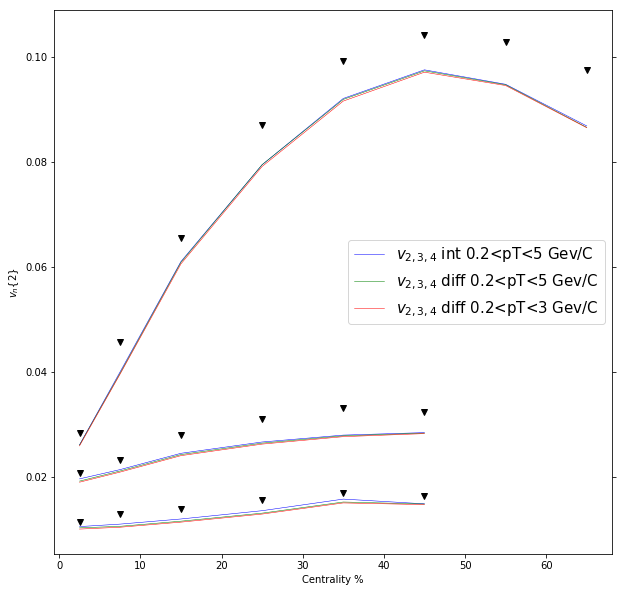

In [13]:
import matplotlib.pyplot as plt

v2_data = [.028389,.045659,.065509,.087069,.0990999,.104139,.102859,.09746]
v3_data = [.02067,.02319,.02799,.030929,.03314,.03234]
v4_data = [.011459,.012909,.01383,.015679,.01702,.016289]

ax = plt.subplot(111)

    # experimental data
plt.plot(cenM,v2_data,'kv')
plt.plot(cenM[0:6],v3_data,'kv')
plt.plot(cenM[0:6],v4_data,'kv')

    # pT-differential calculation using the cuts in this script
# plt.plot(cenM,vn[0],'b', linewidth=2.5, label='$v_2$')
# plt.plot(cenM[0:6],vn[1][0:6],'g', linewidth=2.5, label='$v_3$')
# plt.plot(cenM[0:6],vn[2][0:6],'r', linewidth=2.5, label='$v_4$')

    # pT-integrated calculation for [0.15,5 GeV] 
plt.plot(cenM,v2_int_0_2_5,'b', linewidth=.5, label='$v_{2,3,4}$ int 0.2<pT<5 Gev/C')
plt.plot(cenM[0:6],v3_int_0_2_5,'b', linewidth=.5)
plt.plot(cenM[0:6],v4_int_0_2_5,'b', linewidth=.5)

    # pT-differential calculation for [0.15,5 GeV] 
plt.plot(cenM,v2_diff_0_2_5,'g', linewidth=.5, label='$v_{2,3,4}$ diff 0.2<pT<5 Gev/C')
plt.plot(cenM[0:6],v3_diff_0_2_5,'g', linewidth=.5)
plt.plot(cenM[0:6],v4_diff_0_2_5,'g', linewidth=.5)

        # pT-differential calculation for [0.15,3 GeV] 
plt.plot(cenM,v2_diff_0_2_3,'r', linewidth=.5, label='$v_{2,3,4}$ diff 0.2<pT<3 Gev/C')
plt.plot(cenM[0:6],v3_diff_0_2_3,'r', linewidth=.5)
plt.plot(cenM[0:6],v4_diff_0_2_3,'r', linewidth=.5)

plt.rcParams["figure.figsize"] = [10,10]  #[3.5, 4] 
#ax.set_ylim(ymin=0, ymax=.12)
plt.xlabel('Centrality %')
plt.ylabel('$v_n${2}')
ax.yaxis.set_ticks_position('both')
#plt.yscale("log")
ax.legend(prop={'size': 15})
plt.savefig('vn.png', bbox_inches='tight', dpi=300)
plt.show()